In [12]:
### import libraries and data; define fncs
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as rnd
import numpy as np
np.set_printoptions(threshold=1000, linewidth=200)
import matplotlib
matplotlib.use('Qt5Agg')  # Use TkAgg backend to prevent segmentation fault
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.ticker as ticker
import os
import functools


def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def load_data(str_):
    path_ = os.path.dirname(os.getcwd()) + '/sc_project/test_data/' # Path(__file__).resolve().parents[1]
    with open(path_+str_,'rb') as file_:
        # param = pickle.load(file_)
        param_ = jnp.load(file_,allow_pickle=True)
    return param_

file_ = 'move_loop_v2_data_27_07-161313.pkl' # _'move_loop_v1_26_07-093804.pkl' # move_loop_v1__25_07-161050.pkl
(r_arr,rt_arr,sample_arr,switch_arr,pos_arr,plan_pos_arr,dot_arr) = load_data(file_) # ,sel
print('r_arr.shape=',r_arr.shape,'rt_arr.shape=',rt_arr.shape,'sample_arr.shape=',sample_arr.shape,'switch_arr.shape=',switch_arr.shape,'pos_arr.shape=',pos_arr.shape,'plan_pos_arr.shape=',plan_pos_arr.shape,'dot_arr.shape=',dot_arr.shape)
print('plan_rate=',jnp.mean(sample_arr),'switch_rate=',jnp.mean(switch_arr))

total_rewards = jnp.sum(r_arr, axis=1)
sorted_reward_desc = jnp.argsort(total_rewards)[::-1]
total_plans = jnp.sum(sample_arr, axis=1)
sorted_plan_desc = jnp.argsort(total_plans)[::-1]
total_switches = jnp.sum(switch_arr, axis=1)
sorted_switch_desc = jnp.argsort(total_switches)[::-1]
# sorted_indices_asc = jnp.argsort(total_rewards)
print('sorted_reward_desc=',sorted_reward_desc[:10])
print('sorted_plan_desc=',sorted_plan_desc[:10])
print('sorted_switch_desc=',sorted_switch_desc[:10])
# print('sorted_indices_asc=',sorted_indices_asc)

VMAPS = r_arr.shape[0]
IT = r_arr.shape[1]

r_arr.shape= (1500, 30) rt_arr.shape= (1500, 30) sample_arr.shape= (1500, 30) switch_arr.shape= (1500, 30) pos_arr.shape= (1500, 30, 2) plan_pos_arr.shape= (1500, 30, 2) dot_arr.shape= (1500, 30, 2)
plan_rate= 0.0036222222 switch_rate= 0.06391111
sorted_reward_desc= [ 435 1311  102 1327  752 1173  608 1434  919  242]
sorted_plan_desc= [ 714  666  530  290  282 1493 1459 1457 1448 1446]
sorted_switch_desc= [1499 1498 1497 1496 1495 1494 1493 1492 1490 1489]


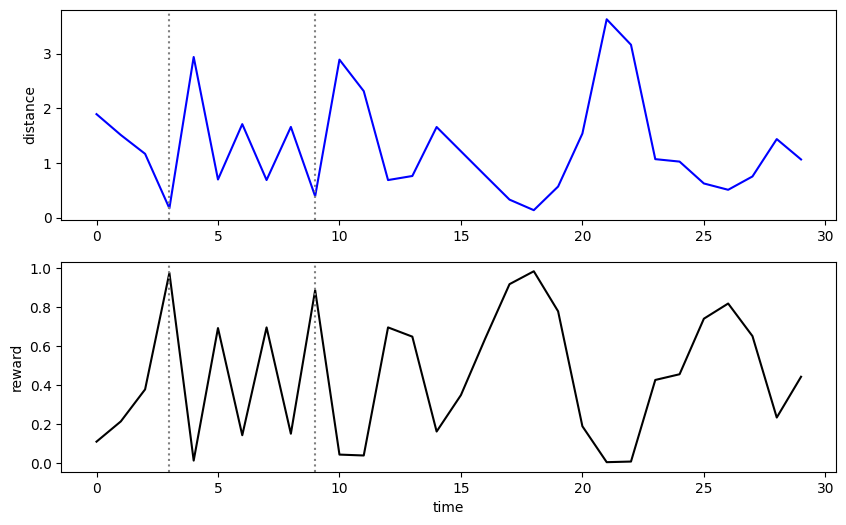

In [33]:
# plot of position / reward timeseries
%matplotlib inline
k = 1494

time_points = np.arange(IT)
agent_t = pos_arr[k,:,:].T
dot_t = dot_arr[k,:,:].T
dis_t = np.linalg.norm(mod_(agent_t - dot_t), axis=0)
rt_t = rt_arr[k,:].T
switch_t = switch_arr[k,:].T

fig,axis = plt.subplots(2,1,figsize=(10, 6))

axis[0].plot(time_points, dis_t, color='b', label='Euclidean Distance')
for t in time_points[switch_t == 1]:
    axis[0].axvline(t-1, color='gray', linestyle='dotted')
axis[0].set_ylabel('distance')
axis[1].plot(time_points, rt_t, color='k', label='Reward')
for t in time_points[switch_t == 1]:
    axis[1].axvline(t-1, color='gray', linestyle='dotted')
axis[1].set_xlabel('time')
axis[1].set_ylabel('reward')
plt.show()

# change y to be in pi's

In [20]:
# animation of timeseries data
# plt.ion()

# fncs

def animate(i,agent_t,agent,dot,dot_t,aperture,aperture_points,agent_plan,aperture_plan_points,agent_plan_t,switch_t):
    dot.set_data([mod_(dot_t[0, i])], [mod_(dot_t[1, i])])
    agent_plan.set_data([mod_(agent_plan_t[0,i])], [mod_(agent_plan_t[1,i])])
    agent.set_data([mod_(agent_t[0,i])], [mod_(agent_t[1,i])])

    # switch condition
    if i == 0:
        aperture_points.set_color('green')
    elif switch_t[i] == 1:
        aperture_points.set_color('blue')
    else:
        aperture_points.set_color('black')

    # plan aperture
    x_aperture_plan,y_aperture_plan = get_aperture_points(agent_plan_t[:,i],aperture)
    x_aperture_plan_mod = mod_(x_aperture_plan)
    y_aperture_plan_mod = mod_(y_aperture_plan)
    
    aperture_plan_points_offsets = np.hstack((np.reshape(x_aperture_plan_mod,(-1,1)),np.reshape(y_aperture_plan_mod,(-1,1))))
    aperture_plan_points.set_offsets(aperture_plan_points_offsets)

    # agent aperture
    x_aperture,y_aperture = get_aperture_points(agent_t[:,i],aperture)
    
    aperture_points_offsets = np.hstack((np.reshape(mod_(x_aperture),(-1,1)),np.reshape(mod_(y_aperture),(-1,1))))
    aperture_points.set_offsets(aperture_points_offsets)

    return agent, dot, aperture_points, agent_plan, aperture_plan_points,

def get_aperture_points(agent_t, aperture, density=100):
    x_horizontal = np.linspace(agent_t[0] - aperture, agent_t[0] + aperture, density)
    y_top = np.full(density, agent_t[1] + aperture)
    y_bottom = np.full(density, agent_t[1] - aperture)

    y_vertical = np.linspace(agent_t[1] - aperture, agent_t[1] + aperture, density)
    x_left = np.full(density, agent_t[0] - aperture)
    x_right = np.full(density, agent_t[0] + aperture)
    
    x_tot = np.concatenate([x_left, x_right, x_horizontal, x_horizontal])
    y_tot = np.concatenate([y_vertical, y_vertical, y_bottom, y_top])
    return x_tot,y_tot

# generate timeseries, hp's
time_points = np.arange(IT) #np.linspace(0,IT-1,IT)
aperture = np.pi/2
interval = 400 # ms

# select data
k = 1494 # 1499 # 3
agent_t = pos_arr[k,:,:].T # 2,IT
dot_t = dot_arr[k,:,:].T # 2,IT
agent_plan_t = plan_pos_arr[k,:,:].T # 2,IT
switch_t = switch_arr[k,:] # IT

# fig/ticks/labels
fig, ax = plt.subplots(figsize=(6, 6))  # square figure
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
ax.set_aspect('equal', 'box')  # Ensuring the aspect ratio is equal
ticks = np.arange(-np.pi, np.pi+1, np.pi/2)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
labels = ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# initialise agent/dot/aper
agent_plan, = ax.plot(mod_(agent_plan_t[0,0]), mod_(agent_plan_t[1,0]), color='lightgrey', marker='+', markersize=12, label='Planned Agent')
agent, = ax.plot(mod_(agent_t[0,0]), mod_(agent_t[1,0]), 'k+', markersize=12, label='Agent')
dot, = ax.plot(mod_(dot_t[0,0]), mod_(dot_t[1,0]), 'rx', markersize=10, label='Dot')
aperture_plan_points = ax.scatter([], [], color='lightgrey', s=1)
aperture_points = ax.scatter([], [], color='black', s=1)

# animate
animate_partial = functools.partial(
    animate, 
    agent_t=agent_t,
    agent=agent,
    dot=dot,
    dot_t=dot_t,
    aperture=aperture,
    aperture_points=aperture_points,
    agent_plan=agent_plan,
    aperture_plan_points=aperture_plan_points,
    agent_plan_t=agent_plan_t,
    switch_t=switch_t
)

ani = animation.FuncAnimation(
    fig, animate_partial, frames=len(time_points), interval=interval, repeat=True
)

ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3)
plt.show()

KeyboardInterrupt: 

In [ ]:
# example animation

# generate timeseries
time_points = np.linspace(0, 10, 100)
agent_x = np.sin(time_points) * np.pi  
agent_y = np.cos(time_points) * np.pi

# random initial position / velocity
dot_speed = 10  # Speed of the dot
initial_angle = 2 * np.pi * np.random.rand((2)) - np.pi  # Random value between [-π, π]
angular_velocity = (2 * np.pi * np.random.rand((2)) - np.pi) / 10  # Random angular velocity

# angular trajectory of dot
dot_xy = mod_(initial_angle + dot_speed*np.outer(angular_velocity, time_points).T).T

# fig/ticks/labels
fig, ax = plt.subplots(figsize=(6, 6))  # square figure
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
ax.set_aspect('equal', 'box')  # Ensuring the aspect ratio is equal
ticks = np.arange(-np.pi, np.pi+1, np.pi/2)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
labels = ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# initialise agent/dot
agent, = ax.plot(agent_x[0], agent_y[0], 'k+', markersize=12, label='Agent')
dot, = ax.plot(dot_xy[0,0], dot_xy[1,0], 'rx', markersize=8, label='Dot')
aperture_size = np.pi
# agent_aper1 = plt.Rectangle((agent_x[0]-aperture_size/2, agent_y[0]-aperture_size/2), aperture_size, aperture_size, fill=False, color='lightgrey')
# agent_aper2 = plt.Rectangle((-3*np.pi, -3*np.pi), aperture_size, aperture_size, fill=False, color='lightgrey') # Initially out of view
# ax.add_patch(agent_aper1)
# ax.add_patch(agent_aper2)
# aperture_x = [agent_x[0]-aperture_size/2, agent_x[0]+aperture_size/2, agent_x[0]+aperture_size/2, agent_x[0]-aperture_size/2, agent_x[0]-aperture_size/2]
# aperture_y = [agent_y[0]-aperture_size/2, agent_y[0]-aperture_size/2, agent_y[0]+aperture_size/2, agent_y[0]+aperture_size/2, agent_y[0]-aperture_size/2]
# agent_aperture_line, = ax.plot(aperture_x, aperture_y, color='lightgrey')
line, = ax.plot([], [], color='lightgrey')

def get_aperture_outline(agent_x, agent_y, aperture_size):
    # Define the aper corners
    corners_x = [agent_x-aperture_size/2, agent_x+aperture_size/2, agent_x+aperture_size/2, agent_x-aperture_size/2, agent_x-aperture_size/2]
    corners_y = [agent_y-aperture_size/2, agent_y-aperture_size/2, agent_y+aperture_size/2, agent_y+aperture_size/2, agent_y-aperture_size/2]
    return corners_x, corners_y

def animate(i):
    agent_x = agent_x[i]
    agent_y = agent_y[i]
    
    # Get aper outline coordinates
    corners_x, corners_y = get_aperture_outline(agent_x, agent_y, aperture_size)

    # Apply mod_ to aper outline coordinates
    corners_x_mod = [mod_(x) for x in corners_x]
    corners_y_mod = [mod_(y) for y in corners_y]
    
    line.set_data([corners_x_mod], [corners_y_mod])

    return line,

# animate
# def animate(i):
#     agent.set_data(agent_x[i], agent_y[i])
#     dot.set_data(dot_xy[0, i], dot_xy[1, i])

#     # Calculate the 4 corner coordinates of the main aper
#     top_left = [mod_(agent_x[i] - aperture_size/2), mod_(agent_y[i] + aperture_size/2)]
#     top_right = [mod_(agent_x[i] + aperture_size/2), mod_(agent_y[i] + aperture_size/2)]
#     bottom_left = [mod_(agent_x[i] - aperture_size/2), mod_(agent_y[i] - aperture_size/2)]
#     bottom_right = [mod_(agent_x[i] + aperture_size/2), mod_(agent_y[i] - aperture_size/2)]

#     # Determine aper spans based on wrapped coordinates
#     spans_right = top_right[0] < top_left[0]
#     spans_left = bottom_left[0] > bottom_right[0]
#     spans_top = top_left[1] < bottom_left[1]
#     spans_bottom = bottom_left[1] > top_left[1]

#     # Adjust the main agent aper to always be in view
#     agent_aper1.set_xy((agent_x[i] - aperture_size/2, agent_y[i] - aperture_size/2))
#     agent_aper1.set_width(aperture_size if not spans_right else np.pi + agent_x[i])
#     agent_aper1.set_height(aperture_size if not spans_top else np.pi + agent_y[i])

#     # Adjust the secondary aper for the right side
#     if spans_right:
#         agent_aper2.set_xy((-np.pi, agent_y[i] - aperture_size/2))
#         agent_aper2.set_width(top_right[0] + np.pi)
#         agent_aper2.set_height(aperture_size)

#     # Adjust for the left side
#     elif spans_left:
#         agent_aper2.set_xy((agent_x[i] + aperture_size/2, agent_y[i] - aperture_size/2))
#         agent_aper2.set_width(-bottom_left[0] + np.pi)
#         agent_aper2.set_height(aperture_size)

#     # Adjust for the top side
#     elif spans_top:
#         agent_aper2.set_xy((agent_x[i] - aperture_size/2, -np.pi))
#         agent_aper2.set_width(aperture_size)
#         agent_aper2.set_height(top_left[1] + np.pi)

#     # Adjust for the bottom side
#     elif spans_bottom:
#         agent_aper2.set_xy((agent_x[i] - aperture_size/2, agent_y[i] + aperture_size/2))
#         agent_aper2.set_width(aperture_size)
#         agent_aper2.set_height(-bottom_left[1] + np.pi)

#     else:
#         # If no wrapping, hide the secondary aper
#         agent_aper2.set_xy((-3*np.pi, -3*np.pi))
#         agent_aper2.set_width(0)
#         agent_aper2.set_height(0)

#     return agent, dot, agent_aper1, agent_aper2,
# def animate(i):
#     agent.set_data(agent_x[i], agent_y[i])
#     dot.set_data(dot_xy[0,i], dot_xy[1,i])
    
#     # Update aper lines
#     aperture_x = [agent_x[i]-aperture_size/2, agent_x[i]+aperture_size/2, agent_x[i]+aperture_size/2, agent_x[i]-aperture_size/2, agent_x[i]-aperture_size/2]
#     aperture_y = [agent_y[i]-aperture_size/2, agent_y[i]-aperture_size/2, agent_y[i]+aperture_size/2, agent_y[i]+aperture_size/2, agent_y[i]-aperture_size/2]
#     agent_aperture_line.set_xdata(mod_(np.array(aperture_x)))
#     agent_aperture_line.set_ydata(mod_(np.array(aperture_y)))
    
#     return agent, dot, agent_aperture_line,

ani = animation.FuncAnimation(
    fig, animate, frames=len(time_points), interval=50, repeat=True
)

ax.legend()
plt.show()
# plt.ion()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
matplotlib.use('Qt5Agg')
import functools
# plt.ion()

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def animate(i, agent_t, agent, dot, dot_t, aperr_size, aperture_points): # ,agent,agent_x_series,agent_y_series,dot,dot_xy,x_aper,y_aper
    agent.set_data([agent_t[0,i], agent_t[1,i]])
    dot.set_data([dot_t[0, i], dot_t[1, i]])
    
    # Get aper outline coordinates
    x_aper, y_aper = get_aperture_points(agent_t[:,i], aperture_size)
    
    # Apply mod_ to each of the coordinates
    x_aperture_mod = mod_(x_aper)
    y_aperture_mod = mod_(y_aper)
    aperture_points.set_offsets(np.c_[x_aperture_mod, y_aperture_mod])

    return agent, dot, aperture_points,

def get_aperture_points(agent_t, aperture_size, density=100):
    half_size = aperture_size / 2
    
    # Horizontal lines (top and bottom of aper)
    x_horizontal = np.linspace(agent_t[0] - half_size, agent_t[0] + half_size, density)
    y_top = np.full(density, agent_t[1] + half_size)
    y_bottom = np.full(density, agent_t[1] - half_size)
    
    # Vertical lines (left and right of aper)
    y_vertical = np.linspace(agent_t[1] - half_size, agent_t[1] + half_size, density)
    x_left = np.full(density, agent_t[0] - half_size)
    x_right = np.full(density, agent_t[0] + half_size)
    
    # Combine to create the aper outline
    x_combined = np.concatenate([x_left, x_right, x_horizontal, x_horizontal])
    y_combined = np.concatenate([y_vertical, y_vertical, y_bottom, y_top])
    
    return x_combined, y_combined

# generate timeseries, hp's
time_points = np.linspace(0, 10, 100)
aperture_size = np.pi

# fig/ticks/labels
fig, ax = plt.subplots(figsize=(6, 6))  # square figure
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
ax.set_aspect('equal', 'box')  # Ensuring the aspect ratio is equal
ticks = np.arange(-np.pi, np.pi+1, np.pi/2)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
labels = ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# gen agent data
agent_x_series = np.sin(time_points) * np.pi  
agent_y_series = np.cos(time_points) * np.pi
agent_t = np.vstack([agent_x_series, agent_y_series])
aperture_points = ax.scatter([], [], color='lightgrey', s=1)  # s is the marker size
agent, = ax.plot(agent_t[0,0], agent_t[1,0], 'k+', markersize=12, label='Agent')

# gen dot data
dot_speed = 10  # Speed of the dot
initial_angle = 2 * np.pi * np.random.rand((2)) - np.pi  # Random value between [-π, π]
angular_velocity = (2 * np.pi * np.random.rand((2)) - np.pi) / 10  # Random angular velocity
dot_t = mod_(initial_angle + dot_speed*np.outer(time_points, angular_velocity)).T
dot, = ax.plot(dot_t[0,0], dot_t[1,0], 'rx', markersize=8, label='Dot')

# animate
animate_partial = functools.partial(
    animate, 
    agent_t=agent_t, 
    agent=agent, 
    dot=dot, 
    dot_t=dot_t, 
    aperture_size=aperture_size, 
    aperture_points=aperture_points
)

ani = animation.FuncAnimation(
    fig, animate_partial, frames=len(time_points), interval=50, repeat=True
)

ax.legend()
plt.show()